In [3]:
%load_ext autoreload
%autoreload 2
import openai_calls
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import seaborn as sns 
import time 
import matplotlib.pyplot as plt 
sns.set()
sns.set_style('whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Risk aversion and AI 

*Question*
- Does GPT-3 exhibit risk aversion, in the sense of prospect theory? If so, it may not exhibit the advanced decision making capabilities we might be looking for. 
- In particular, does GPT-3 favour certainty (perhaps with a discount), as opposed to gambles? - Knowing might help us measure GPT-3's views on risk taking. 
This could be applied to situations in safety, or risk taking in markets. 


*Methodology*
- Here, we adapt a section of the work of [1], offering GPT-3 a choice between 
a gamble of x dollars, versus a certain win of x dollars plus a discount. 
- The plots in the notebook below show the probability of choice at different levels of x, 
where the certain choice with a discount is also shown. 


*Results*
- GPT-3 seems to show a lot of risk aversion, showing preference 
even up to a 80% discount. 
- This seems robust to different levels of reward.


*References* 
- Binz, Marcel, and Eric Schulz. 2022. “Using Cognitive Psychology to Understand GPT-3.” PsyArXiv. June 21. doi:10.31234/osf.io/6dfgk.

In [4]:
min_amount = 0
max_amount = 1e20
increments = 20
certain_pct_reduction = 0

dollar_range = np.linspace(min_amount, 
                           max_amount, 
                           increments)
reductions = [1, 2, 10, 20, 40, 80]

default_question = "Q: Which option do you prefer?\n\n"
res = defaultdict(dict)

def choice_probs(task):
    response = openai_calls._get_completion(
            task)
    choice = (response
              .choices[0]
              .text
              .strip()) 
    log_probs = (response
                 .choices[0]
                 .logprobs
                 .top_logprobs[0]
                )
    return log_probs.keys(), log_probs.values() 
    

for i in tqdm(dollar_range):
    for j in tqdm(reductions):
    
        task = (default_question 
                + f"- Option F: 50% chance at {i} dollars and a 50% chance at 0\n"\
        f"- Option J: Guaranteed {i * .5 * (1 - j/ 100)} dollars.\n" 
                +  "\nA: Option")
        
        choices, probs = choice_probs(task)
        res[(j, i)].update(
            zip(choices, probs)
        )
    time.sleep(5)
    

  5%|████                                                                            | 1/20 [00:11<03:43, 11.74s/it]


KeyboardInterrupt: 

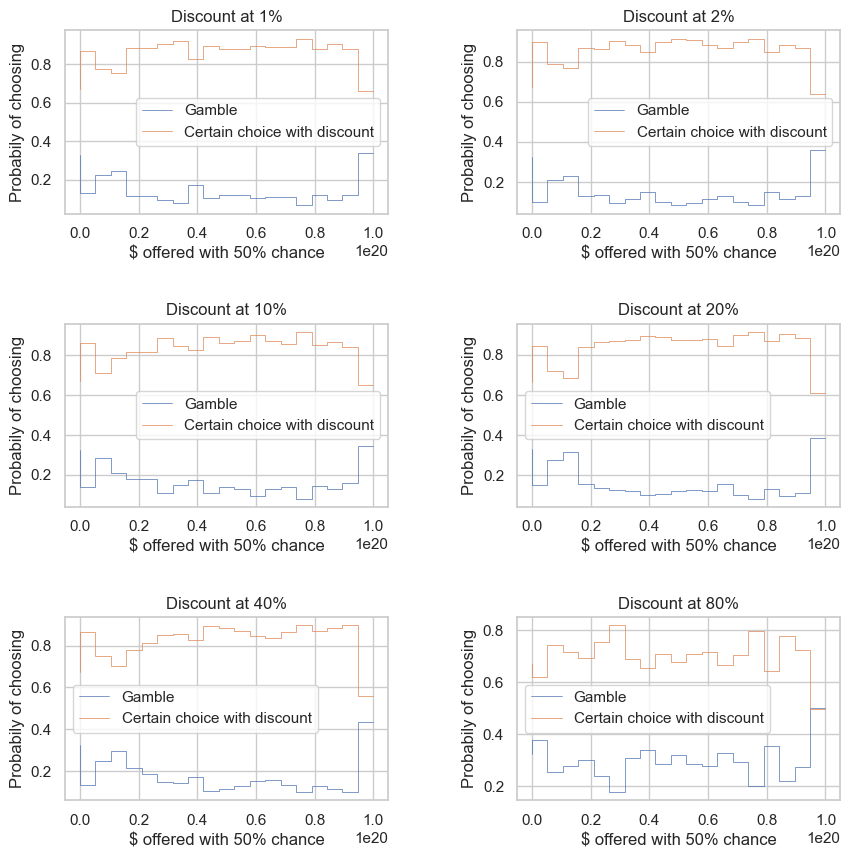

In [144]:
results = (pd
 .read_pickle(
     'results')
 .unstack()
)

fig, ax = plt.subplots(
    int(len(reductions) / 2), 2, 
    figsize = (10, 10)
)
    
probs = np.exp(results).T
for ix, col in enumerate(probs.columns):
    (probs
     .loc[:,  col]
     .unstack()
     .T
     .plot(ax
           = ax.flatten()[ix], 
           linewidth = .5, 
           drawstyle = 'steps'
          )
    )
    
    axplot = ax.flatten()[ix]
    axplot.set_title(f'Discount at {col}%')
    axplot.set_xlabel('$ offered with 50% chance')
    axplot.set_ylabel('Probabily of choosing')
    axplot.legend(
        ['Certain choice with discount', 
         'Gamble'][::-1]
    )
    
plt.subplots_adjust(
    wspace = 0.4,
    hspace = 0.6, 
)
    

#### The setup and motivation 
There are plenty of examples in which GPT-3 has made 'obviously' bad decisions. Here is another simple game that leads to an unexpected decision when it comes to a question of choice. Consider a game where we flip two unfair coins. Our reward is $10 for each 
head we get. 
- The first coin has a 0% probability of scoring heads.  
- The second coin has a 5% probability of scoring heads. 

We have a choice to bump the probability of either coin by 5%. Mathematically, the choice of coin to bump shouldn't matter, 
the expected value of the game increases by the same amount. Inspired by this game, I asked GPT-3 several variants of the question below. I expected that it would approach either choice with a 50% probability.  

Q: Which choice offers a better improvement?
- Option F: A probability increase from 0% to 5%, to win x dollars
- Option J: A probability increase from 5% to 10%, to win x dollars.

#### Results
- It looks like GPT-3 seems to favour the latter choice for different (seemingly all) values of x. This is weird, and an unexpected result. 
- The result seems robust to multiple wordings of the question. 

In [40]:
wordings = [ 
    "Q: Which choice offers a larger improvement?\n\n", 
    "Q: Which choice offers a better improvement?\n\n",
    "Q: Which choice offers a more favourable improvement?\n\n"
]

min_amount = 0
amount_stake = 1000
increments = 11
dollar_range = np.linspace(min_amount, 
                           amount_stake, increments)

res = defaultdict(dict)
for q in wordings:
    for i in tqdm(dollar_range):

        task = (q 
                + f"- Option F: A probability increase from 0% to 5%, to win {amount_stake} dollars. \n"\
        f"- Option J: A probability increase from 5% to 10%, to win {amount_stake} dollars. \n" 
                +  "\nA: Option")

        choices, probs = choice_probs(task)
        res[(q, i)].update(zip(choices, probs))

100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:11<00:00,  1.03s/it]


In [46]:
df = pd.DataFrame.from_dict(res).T.apply(np.exp)
df.columns = ['From 0% to 5%', 'From 5% to 10%']
df.round(3)


From 0% to 5%  \
Q: Which choice offers a larger improvement?\n\n   0.0             0.064   
                                                   100.0           0.065   
                                                   200.0           0.064   
                                                   300.0           0.064   
                                                   400.0           0.067   
                                                   500.0           0.064   
                                                   600.0           0.064   
                                                   700.0           0.065   
                                                   800.0           0.065   
                                                   900.0           0.065   
                                                   1000.0          0.066   
Q: Which choice offers a better improvement?\n\n   0.0             0.070   
                                                   100.0           0.072   
                                                   200.0           0.072   
                                                   300.0           0.072   
                                                   400.0           0.073   
                                                   500.0           0.072   
                                                   600.0           0.071   
                                                   700.0           0.072   
                                                   800.0           0.071   
                                                   900.0           0.072   
                                                   1000.0          0.071   
Q: Which choice offers a more favourable improv... 0.0             0.114   
                                                   100.0           0.113   
                                                   200.0           0.111   
                                                   300.0           0.111   
                                                   400.0           0.111   
                                                   500.0           0.112   
                                                   600.0           0.113   
                                                   700.0           0.112   
                                                   800.0           0.113   
                                                   900.0           0.113   
                                                   1000.0          0.112   

                                                           From 5% to 10%  
Q: Which choice offers a larger improvement?\n\n   0.0              0.934  
                                                   100.0            0.933  
                                                   200.0            0.934  
                                                   300.0            0.934  
                                                   400.0            0.932  
                                                   500.0            0.934  
                                                   600.0            0.934  
                                                   700.0            0.934  
                                                   800.0            0.933  
                                                   900.0            0.933  
                                                   1000.0           0.932  
Q: Which choice offers a better improvement?\n\n   0.0              0.928  
                                                   100.0            0.926  
                                                   200.0            0.926  
                                                   300.0            0.927  
                                                   400.0            0.926  
                                                   500.0            0.926  
                                                   600.0            0.927  
                              